# Implementation of Neural Algorithm of Artistic Style using PyTorch

#### Pakages installed

In [1]:
# !pip install torch
# !pip install torchvision

## Introduction
Below code is the implementaion of Neural-Style algorithm developed by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge. I have just used tutorial from pytouch to implement the given task

- [Tutorial Link](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)
- [Research Paper](https://arxiv.org/pdf/1508.06576.pdf)

### Necesarry Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

### Loading Images
Images are converted into pytorch tensors and are resized to same size of 512

In [8]:
import torch
from torchvision import transforms
from PIL import Image

# desired size of the output image
imsize = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # set the desired size
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("style.jpeg")
content_img = image_loader("content.jpeg")

assert style_img.size() == content_img.size(), \
    "Style and content images must be of the same size"

# Check the size of the images
print("Style Image Size:", style_img.size())
print("Content Image Size:", content_img.size())


Style Image Size: torch.Size([1, 3, 512, 512])
Content Image Size: torch.Size([1, 3, 512, 512])


Figures are just plot below

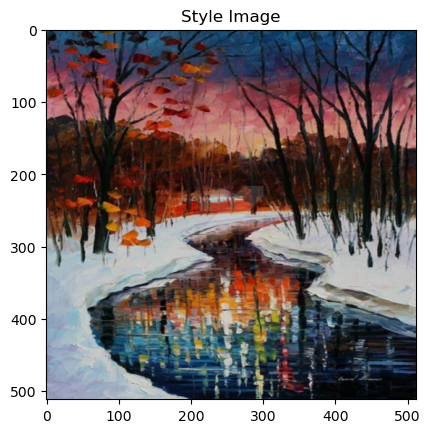

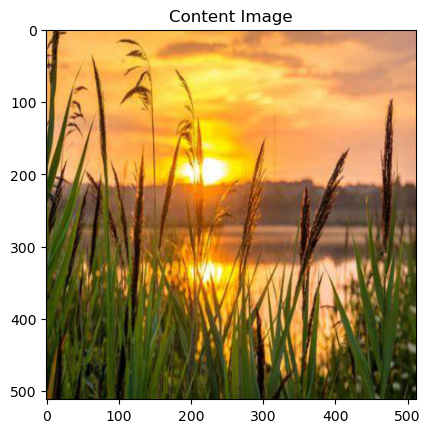

In [9]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

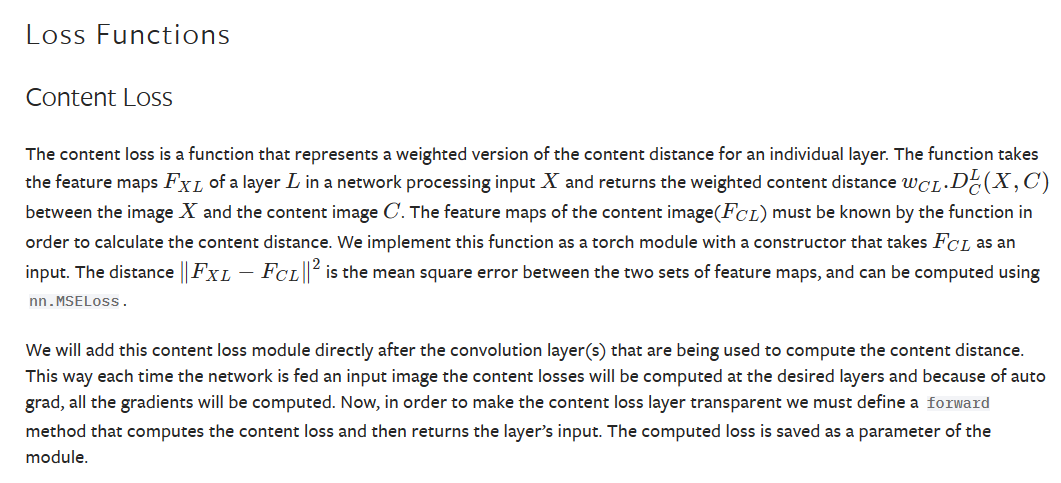

In [10]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

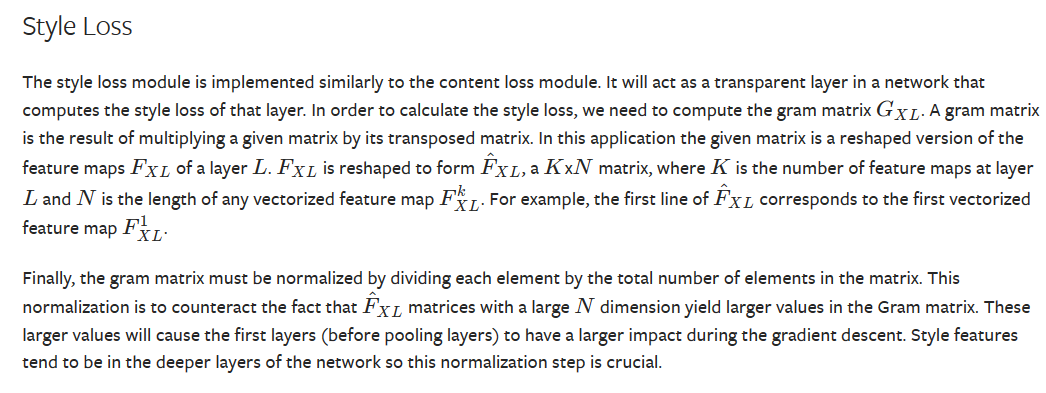

In [11]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [12]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Importing the Model

In [13]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\hp/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [00:50<00:00, 11.4MB/s]


## About VGG19
VGG19 is a convolutional neural network model that has 19 layers, including 16 convolution layers, 3 fully connected layers, 5 max pooling layers, and 1 softmax layer. It is a variant of the VGG model, which was developed by the Visual Geometry Group at Oxford University. VGG19 is very deep and has been trained on millions of diverse images with complex classification tasks. It has 19.6 billion floating point operations per second (FLOPs)

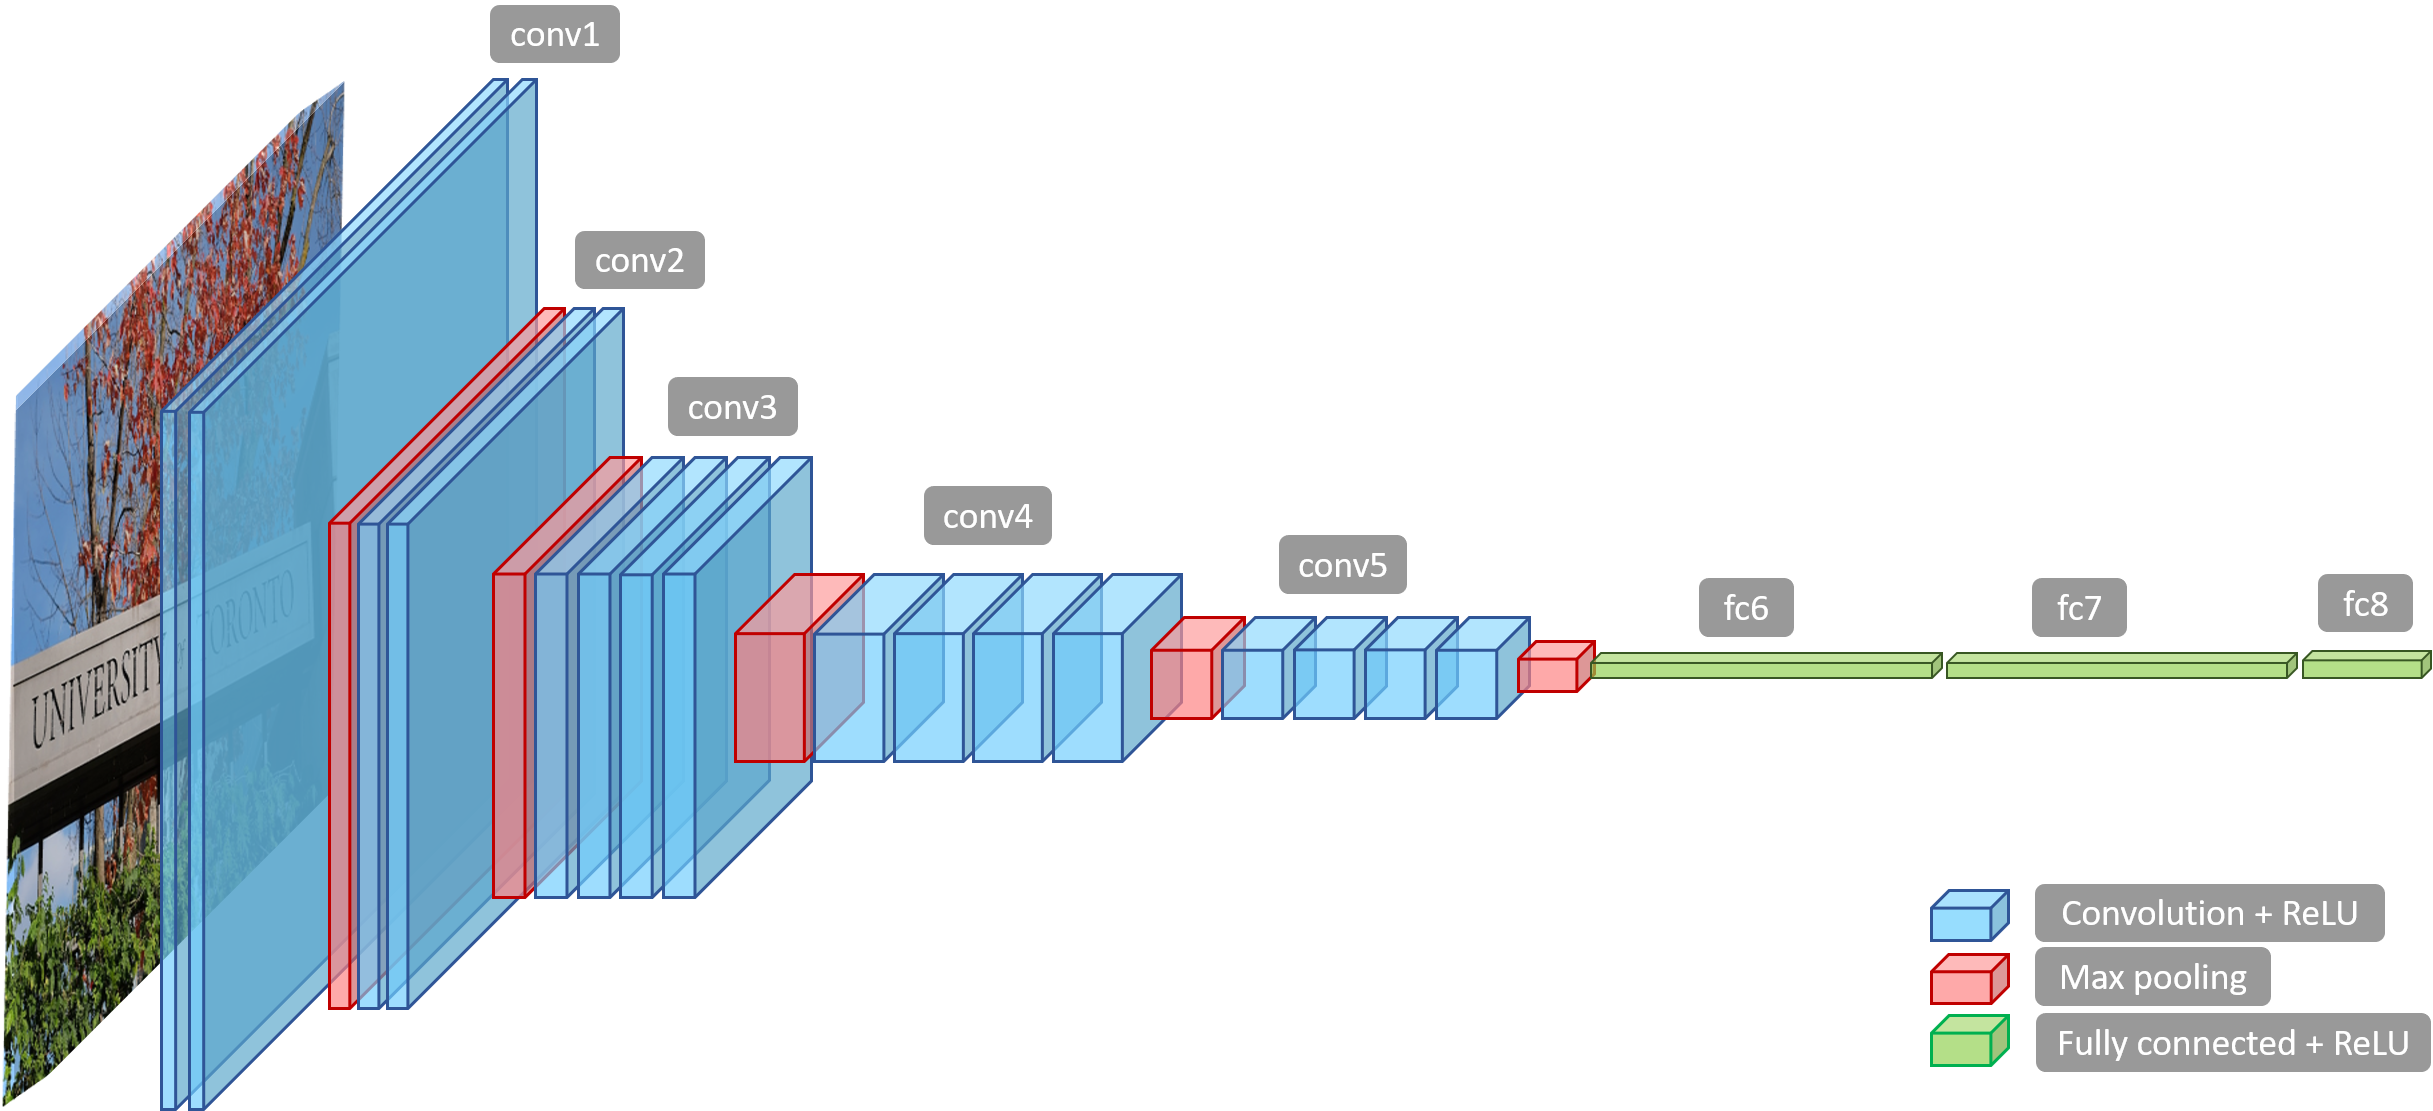

#### Normalization of Image

In [14]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [15]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

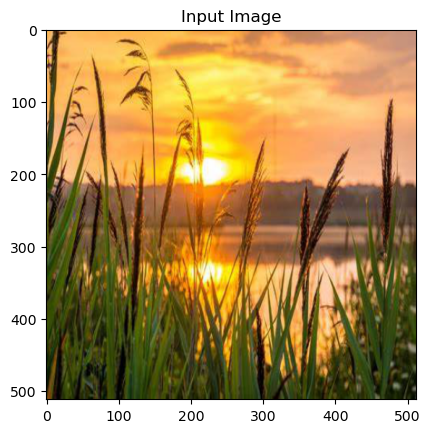

In [19]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:

# ::


# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

## Optimizer

### L-BFGS algorithm
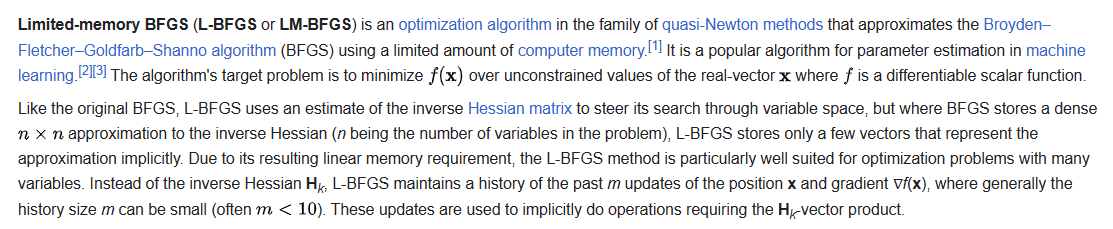

[Refrence](https://en.wikipedia.org/wiki/Limited-memory_BFGS)

In [20]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [21]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

### Neural Algorithm of Artistic Style

#### Model Overview:

The Neural Algorithm of Artistic Style, based on the paper by Leon Gatys et al., utilizes a pre-trained Convolutional Neural Network (CNN) like VGG for image classification.

1. **Content and Style Representation:**
   - Content is captured by high-layer activations, representing complex structures.
   - Style is encoded by correlations between activations, capturing textures and patterns.

2. **Loss Function:**
   - Content loss measures differences in content between generated and target images.
   - Style loss measures differences in style between generated and reference images.
   - Total loss is a weighted sum of content and style losses.

#### Optimization Process:

1. **Initialization:**
   - Start with an initialized image, often random noise or a copy of the content image.

2. **Forward Pass:**
   - Compute content and style representations by passing the generated image through the pre-trained network.

3. **Loss Computation:**
   - Calculate content loss by comparing higher layer activations.
   - Compute style loss by comparing correlations between activations.
   - Total loss is a weighted sum of content and style losses.

4. **Backward Pass:**
   - Compute gradients of total loss with respect to pixel values.

5. **Update Image:**
   - Update pixel values in the direction that minimizes the total loss.

6. **Iteration:**
   - Repeat steps 2-5 iteratively until the image converges, blending content and style.


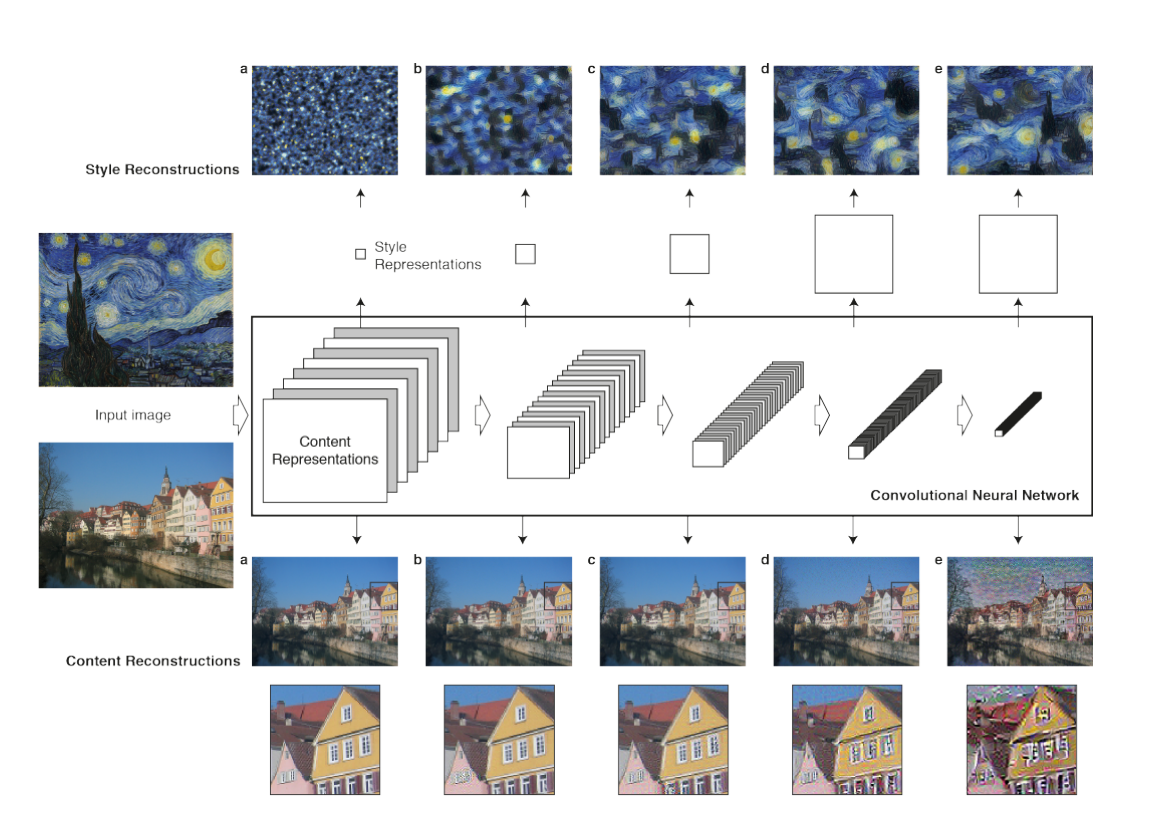

Building the style transfer model..


C:\Users\hp\anaconda3\Lib\site-packages\torch\utils\_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 100.926979 Content Loss: 20.167990

run [100]:
Style Loss : 33.608372 Content Loss: 17.935169

run [150]:
Style Loss : 14.830737 Content Loss: 15.455854

run [200]:
Style Loss : 7.454502 Content Loss: 13.628596

run [250]:
Style Loss : 4.701549 Content Loss: 12.260332

run [300]:
Style Loss : 3.090664 Content Loss: 11.237318



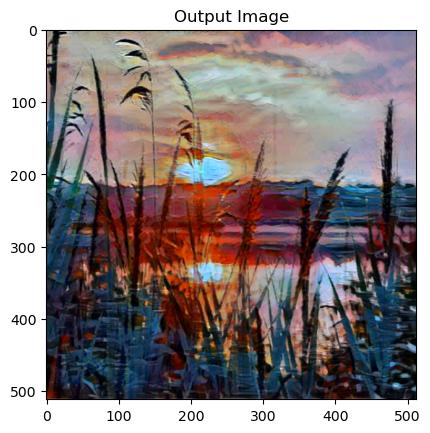

In [22]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

## Limitaion

1. **Computational Intensity:** The optimization process is computationally intensive and time-consuming, especially for high-resolution images. Real-time applications may face challenges.

2. **Single Style Transfer:** The model is designed for a one-to-one style transfer. Applying multiple styles to a single image or transferring styles between more than two images can be complex.

3. **Dependence on Pre-trained Models:** The effectiveness of the model relies on the quality of the pre-trained CNN. Issues like biases present in the training data may transfer to the generated images.

4. **Lack of Semantic Control:** The model does not consider semantic content explicitly. As a result, the generated image may not always respect the semantic context, potentially leading to distortions in important objects.

5. **Parameter Sensitivity:** The model's performance is sensitive to hyperparameters such as the weights assigned to content and style losses. Finding the right balance is crucial and may require manual tuning.

6. **Limited Style Understanding:** The model captures style at a global level but may struggle with understanding and replicating intricate local styles or nuanced artistic elements.

7. **Style and Content Mismatch:** Balancing content and style can be challenging, especially when the content and style images have significant differences in structure or complexity.

8. **Artifacts and Over-smoothing:** The optimization process might introduce artifacts or over-smooth certain regions, impacting the fidelity of the generated image.

9. **Need for Reference Image:** Style transfer requires a reference image for the desired style. This dependence on a separate style reference can be limiting in some applications.

10. **Limited Transferability Across Domains:** The model may not perform well when transferring styles between images with drastically different content or when the content does not align with the assumptions made during training.


Above is the output of following above model. Although the model is not made by me and above process is just the implementaion of doucumentation provided by pytorch. But the whole procedure is giving the desire result as mentioned in task. I belive its just waste of time and resource if we try to make whole thing from scrach. Various resources and models have been devloped and can be found easily on internet to perform desire task. 